In [1]:
from xgboost import XGBClassifier
import pandas as pd
from aix360.algorithms.glance.iterative_merges.iterative_merges import IterativeMerges
from aix360.algorithms.glance.counterfactual_tree.counterfactual_tree import CounterfactualTree
from aix360.datasets.heloc_dataset import HELOCDataset
from sklearn.model_selection import train_test_split

In [2]:
data = HELOCDataset()
df = data.dataframe()

Using Heloc dataset:  c:\users\nikolastheol\documents\github\aix360\aix360\datasets\..\data\heloc_data\heloc_dataset.csv


c:\users\nikolastheol\documents\github\aix360\aix360\datasets\heloc_dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col].isin([-7, -8, -9])] = 0
c:\Users\NikolasTheol\anaconda3\envs\aix360\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\NikolasTheol\anaconda3\envs\aix360\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [3]:
def preprocess_heloc(df):
    df['RiskPerformance'] = df['RiskPerformance'].replace({'Bad': 0, 'Good': 1})
    return df
df  = preprocess_heloc(df)

In [4]:
X = df.drop(columns='RiskPerformance')
y = df['RiskPerformance']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
num_features = X_train._get_numeric_data().columns.to_list()
cate_features = X_train.columns.difference(num_features)

In [5]:
model = XGBClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
affected = X_test[predictions == 0].reset_index(drop=True)
unaffected = X_test[predictions == 1].reset_index(drop=True)
train_dataset = X_train.copy()


for col in num_features:
    train_dataset[col] = train_dataset[col].astype(float)

    
train_dataset["target"] = y_train
feat_to_vary = list(affected.columns)
target_name = "RiskPerformance"

# C-GLANCE

In [6]:
global_method = IterativeMerges(
    model,
    initial_clusters=100,
    final_clusters=3,
    num_local_counterfactuals=10,
)
global_method.fit(
    df.drop(columns=["RiskPerformance"]),
    df["RiskPerformance"],
    train_dataset,
    feat_to_vary,
)

In [7]:
clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 460/460 [00:29<00:00, 15.38it/s]
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:860: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
AverageMInFile +327.09999999999997 
NumSatisfactoryTrades +69.5 
NumInstallTradesWBalance +20.2 
PercentTradesWBalance +25.400000000000006 

Effectiveness: 89.67%	Cost: 24.73


Action 2 
AverageMInFile +275.4 
NumSatisfactoryTrades +55.8 
NumInstallTradesWBalance +12.3 

Effectiveness: 77.88%	Cost: 17.02


Action 3 
AverageMInFile +282.4 
NumSatisfactoryTrades +60.0 
PercentTradesNeverDelq +15.049999999999997 
MSinceMostRecentDelq +65.7 
NumInstallTradesWBalance +18.25 

Effectiveness: 84.19%	Cost: 28.08


TOTAL EFFECTIVENESS: 89.96%
TOTAL COST: 18.73


# C-GLANCE with Nearest Neighbors Local Cfs

In [6]:
global_method = IterativeMerges(
    model, initial_clusters=100, final_clusters=3, num_local_counterfactuals=10
)
global_method.fit(
    df.drop(columns=["RiskPerformance"]),
    df["RiskPerformance"],
    train_dataset,
    feat_to_vary,
    cf_generator="NearestNeighbors",
)

In [7]:
clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 270/270 [00:18<00:00, 14.70it/s]
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:860: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
ExternalRiskEstimate +12.200000000000003 
MSinceOldestTradeOpen -11.800000000000011 
MSinceMostRecentTradeOpen +23.4 
AverageMInFile +18.19999999999999 
NumSatisfactoryTrades -8.600000000000001 
NumTrades60Ever2DerogPubRec +0.19999999999999996 
NumTrades90Ever2DerogPubRec +0.19999999999999996 
PercentTradesNeverDelq +3.4000000000000057 
MSinceMostRecentDelq +20.8 
MaxDelq2PublicRecLast12M +2.0 
MaxDelqEver -0.7999999999999998 
NumTotalTrades -9.399999999999999 
NumTradesOpeninLast12M -0.8 
PercentInstallTrades +2.0 
MSinceMostRecentInqexcl7days -9.0 
NumInqLast6M -0.4 
NumInqLast6Mexcl7days -0.4 
NetFractionRevolvingBurden +1.0 
NetFractionInstallBurden +29.6 
NumRevolvingTradesWBalance -3.8 
NumInstallTradesWBalance +3.8 
NumBank2NatlTradesWHighUtilization -1.6 
PercentTradesWBalance +16.200000000000003 

Effectiveness: 82.57%	Cost: 16.26


Action 2 
ExternalRiskEstimate +14.0 
MSinceOldestTradeOpen -8.0 
MSinceMostRecentTradeOpen +7.0 
AverageMInFile +24.0 
NumSatisfactoryT

# T-GLANCE

In [8]:
global_method_args_fit = {}
global_method_args_fit["train_dataset"] = train_dataset

In [10]:
cf_tree = CounterfactualTree(model)
cf_tree.fit(df.drop(columns=["RiskPerformance"]), df["RiskPerformance"], train_dataset)

In [11]:
node = cf_tree.partition_group(affected)

100%|██████████| 90/90 [00:07<00:00, 12.43it/s]


In [13]:
node

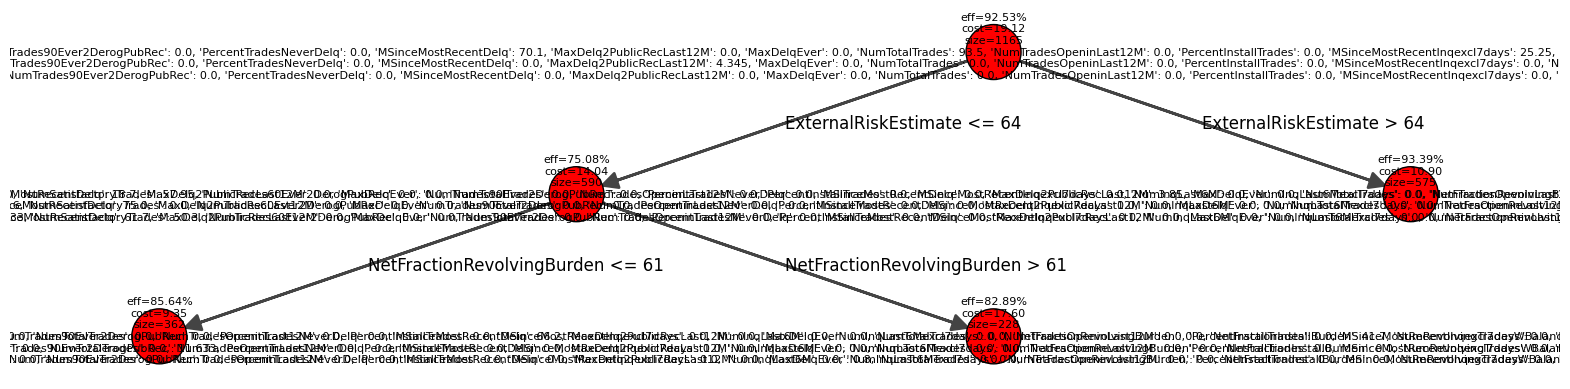

In [16]:
node.display_igraph_jupyter(
    numeric_features=affected.select_dtypes(
        include=["number"]).columns.tolist()
)

In [15]:
cf_tree.cumulative_leaf_actions()


TOTAL EFFECTIVENESS: 95.36%

TOTAL COST: 10.24


(1111, 11371.53039819849, 9)